In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import pickle
import time

In [2]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [13]:
data_raw = pd.read_csv('../pitches.csv')

In [4]:
# Print out size, shape, and column names
print("size: " + str(data_raw.size))
print("shape: " + str(data_raw.shape))
print("columns: " + str(data_raw.columns))

size: 114686160
shape: (2867154, 40)
columns: Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')


In [14]:
df = data_raw
# drop everything except swinging strikes and foul balls
df = df[df.code.isin(['S', 'F'])]
# Convert S/F to 1 and 0 to measure ROC AUC
sf = {'S': 1, 'F': 0}
df.code = [sf[item] for item in df.code]
# only 2-strike counts
df = df[df.s_count == 2]
# dropping useless columns and rows with null values
df = df.drop(["zone", "type_confidence", "pitch_type", "ab_id", "event_num"], axis = 1)
df = df.drop(["y0", "type", "b_score", "outs", "pitch_num", "b_count", "s_count", "on_1b", "on_2b", "on_3b"], axis = 1)
df = df.dropna()

C:\Python39\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
print(df.shape)
df.columns

(283316, 25)


Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'z0', 'pfx_x', 'pfx_z',
       'nasty', 'code'],
      dtype='object')

In [15]:
# balance out the cases
strikes = df[df.code == 1]
fouls = df[df.code == 0]
fouls = fouls[0:len(strikes)]
tojoin = [strikes, fouls]
df = pd.concat(tojoin)
print(strikes.shape)
df.shape

(92995, 25)


(185990, 25)

In [8]:
with open("final_model_files/scaled_models/mlp.pkl", "rb") as mlpr:
    mlp = pickle.load(mlpr)
with open("final_model_files/unscaled_models/ab.pkl", "rb") as abr:
    ab = pickle.load(abr)
with open("final_model_files/unscaled_models/gb.pkl", "rb") as gbr:
    gb = pickle.load(gbr)
with open("final_model_files/unscaled_models/rf.pkl", "rb") as rfr:
    rf = pickle.load(rfr)
with open("final_model_files/scaled_models/ab_scaled.pkl", "rb") as abr:
    ab_scaled = pickle.load(abr)
with open("final_model_files/scaled_models/gb_scaled.pkl", "rb") as gbr:
    gb_scaled = pickle.load(gbr)
with open("final_model_files/scaled_models/rf_scaled.pkl", "rb") as rfr:
    rf_scaled = pickle.load(rfr)
with open("final_model_files/scaled_models/vc.pkl", "rb") as evcr:
    vc = pickle.load(evcr)

In [16]:
import sklearn.model_selection as tts
features_train, features_test, labels_train, labels_test = tts.train_test_split(df.transpose()[:24].transpose(), df.code, test_size = 0.3, random_state = 666)
# IMPORTANT: DO NOT TOUCH VAL UNTIL VALIDATION PHASE!!
features_test, features_val, labels_test, labels_val = tts.train_test_split(features_test, labels_test, test_size = 0.3, random_state = 420)

In [17]:
# Scaling data helps with MLPClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)
features_val_scaled = scaler.transform(features_val)

Fitted in 2524.5831382274628 seconds


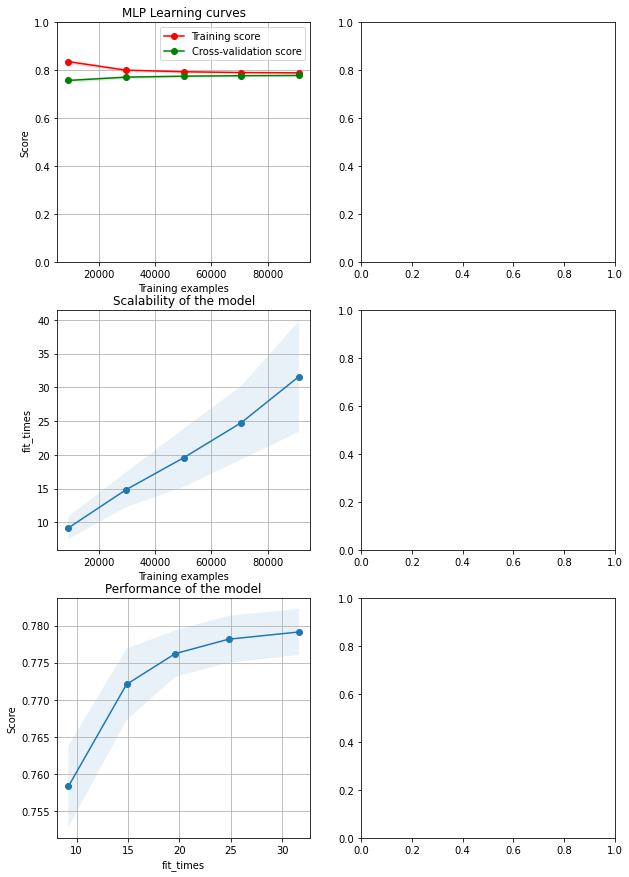

In [72]:
st = time.time()
mlp = MLPClassifier(random_state=1, max_iter=2000)
fig, axes = plt.subplots(3, 2, figsize=(10,15))
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=1)
plot_learning_curve(mlp, "MLP Learning curves", features_train_scaled, labels_train, axes=axes[:,0], ylim=(0,1),cv=cv,n_jobs=4)
print("Fitted in %s seconds" % (time.time() - st))
# The '%s' number is definitly wrong for some readon- it took more like 7 hours to make this graph

In [ ]:
print(mlp.score(features_test_scaled, labels_test))
roc_auc_score(labels_test, mlp.predict_proba(features_test_scaled)[:,1])

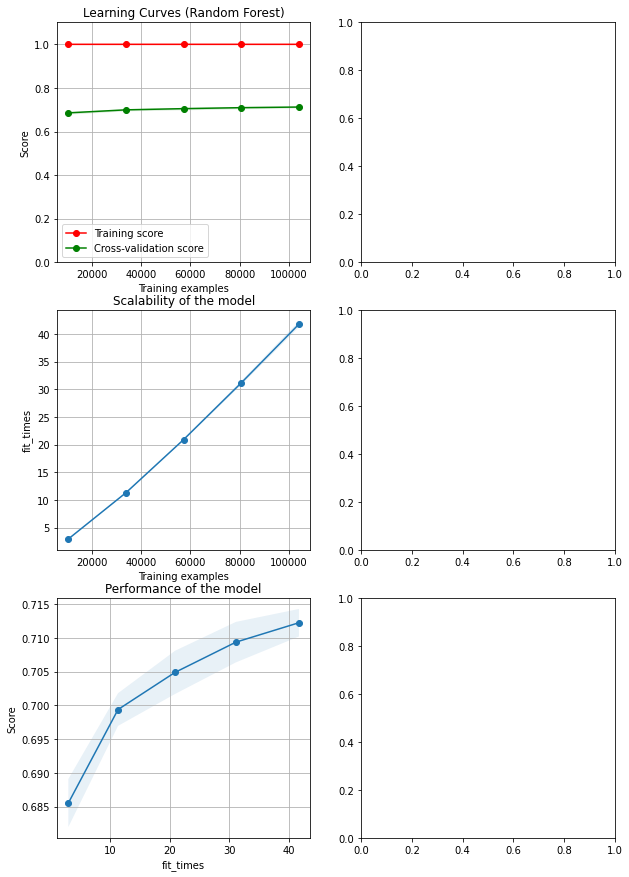

Fitted/plotted in 315.2073037624359 seconds


In [73]:
st = time.time()
fig, axes = plt.subplots(3, 2, figsize=(10,15))
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(RandomForestClassifier(), title, features_train, labels_train, axes=axes[:,0],ylim=(0,1.1),cv=cv,n_jobs=4)
plt.show()
print("Fitted/plotted in %s seconds" % (time.time() - st))

In [56]:
print(rf.score(features_test, labels_test))
roc_auc_score(labels_test, rf.predict_proba(features_test)[:,1])

NameError: name 'rf' is not defined

In [74]:
st = time.time()
rf_scaled = RandomForestClassifier().fit(features_train_scaled, labels_train)
print("Fitted in %s seconds" % (time.time() - st))

Fitted in 50.526992321014404 seconds


In [ ]:
print(rf_scaled.score(features_test_scaled, labels_test))
roc_auc_score(labels_test, rf_scaled.predict_proba(features_test_scaled)[:,1])

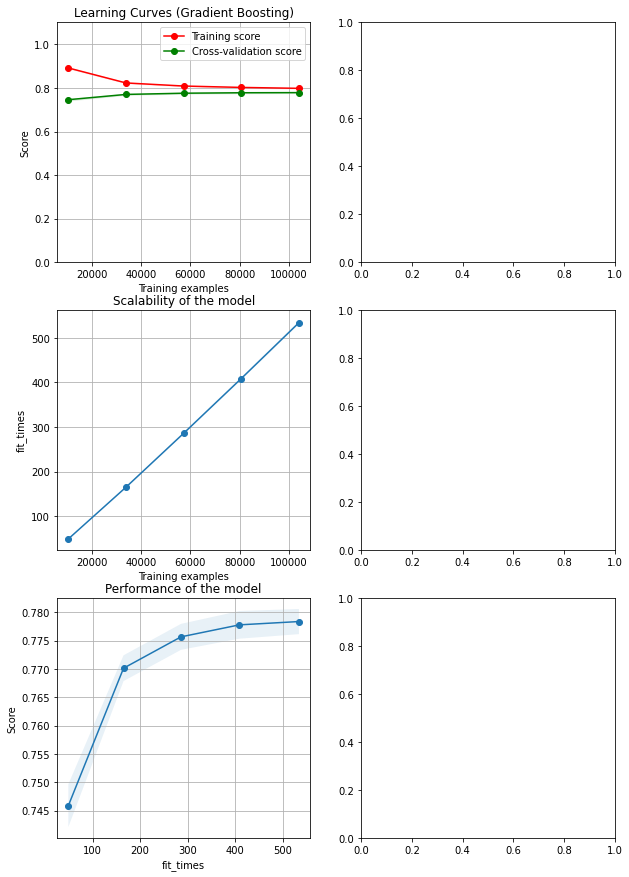

Fitted/plotted in 3849.730815887451 seconds


In [75]:
gb = GradientBoostingClassifier(loss='exponential', n_estimators=1000)
st = time.time()
fig, axes = plt.subplots(3, 2, figsize=(10,15))
title = "Learning Curves (Gradient Boosting)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(gb, title, features_train, labels_train, axes=axes[:,0],ylim=(0,1.1),cv=cv,n_jobs=4)
plt.show()
print("Fitted/plotted in %s seconds" % (time.time() - st))

In [ ]:
print(gb.score(features_test, labels_test))
roc_auc_score(labels_test, gb.predict_proba(features_test)[:,1])

In [76]:
st = time.time()
gb_scaled = GradientBoostingClassifier(loss='exponential', n_estimators = 1000).fit(features_train_scaled, labels_train)
print("Fitted in %s seconds" % (time.time() - st))

Fitted in 670.6763119697571 seconds


In [ ]:
print(gb_scaled.score(features_test_scaled, labels_test))
roc_auc_score(labels_test, gb_scaled.predict_proba(features_test_scaled)[:,1])

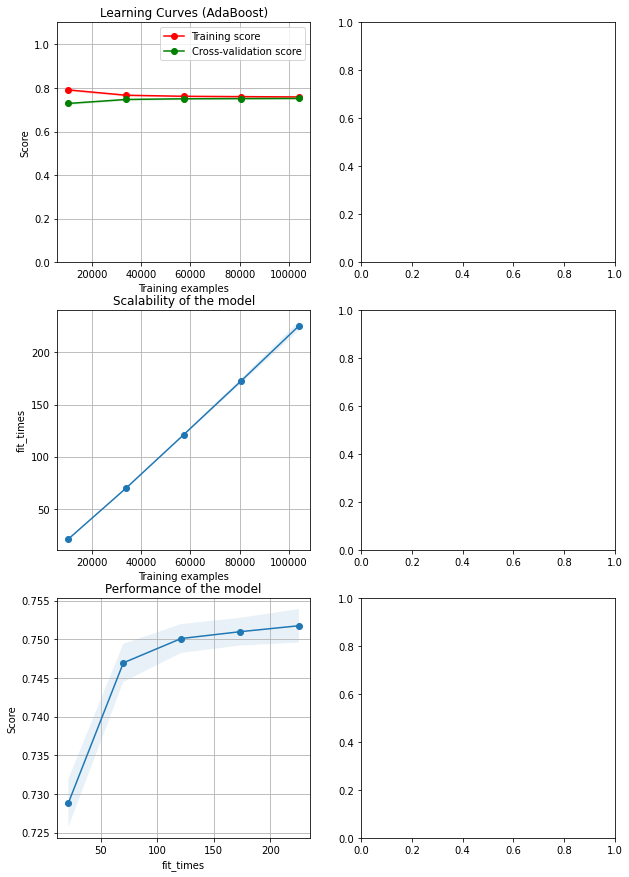

Fitted/plotted in 1772.0692567825317 seconds


In [77]:
ab = AdaBoostClassifier(n_estimators=1000)
st = time.time()
fig, axes = plt.subplots(3, 2, figsize=(10,15))
title = "Learning Curves (AdaBoost)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(ab, title, features_train, labels_train, axes=axes[:,0],ylim=(0,1.1),cv=cv,n_jobs=4)
plt.show()
print("Fitted/plotted in %s seconds" % (time.time() - st))

In [ ]:
print(ab.score(features_test, labels_test))
roc_auc_score(labels_test, ab.predict_proba(features_test)[:,1])

In [78]:
st = time.time()
ab_scaled = AdaBoostClassifier(n_estimators=1000).fit(features_train_scaled, labels_train)
print("Fitted in %s seconds" % (time.time() - st))

Fitted in 258.49971866607666 seconds


In [ ]:
print(ab_scaled.score(features_test_scaled, labels_test))
roc_auc_score(labels_test, ab_scaled.predict_proba(features_test_scaled)[:,1])

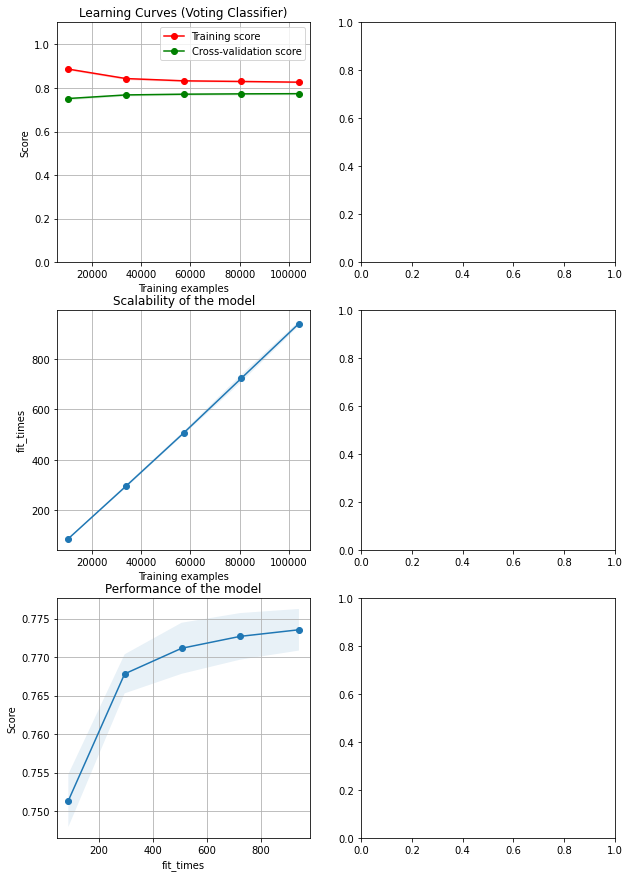

Fitted/plotted in 6971.514023065567 seconds


In [79]:
vc = VotingClassifier(estimators=[('gbs', gb_scaled), ('abs', ab_scaled), ('rfs', rf_scaled), ('mlps', mlp)], voting = 'hard')
st = time.time()
fig, axes = plt.subplots(3, 2, figsize=(10,15))
title = "Learning Curves (Voting Classifier)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(vc, title, features_train_scaled, labels_train, axes=axes[:,0],ylim=(0,1.1),cv=cv,n_jobs=4)
plt.show()
print("Fitted/plotted in %s seconds" % (time.time() - st))

In [ ]:
print(vc.score(features_test_scaled, labels_test))
roc_auc_score(labels_test, vc.predict_proba(features_test_scaled)[:,1])

In [ ]:
with open("final_model_files/scaled_models/mlp.pkl", "wb") as mlpw:
    pickle.dump(mlp, mlpw)
with open("final_model_files/unscaled_models/ab.pkl", "wb") as abw:
    pickle.dump(ab, abw)
with open("final_model_files/unscaled_models/gb.pkl", "wb") as gbw:
    pickle.dump(gb, gbw)
with open("final_model_files/unscaled_models/rf.pkl", "wb") as rfw:
    pickle.dump(rf, rfw)
with open("final_model_files/scaled_models/ab_scaled.pkl", "wb") as abw:
    pickle.dump(ab_scaled, abw)
with open("final_model_files/scaled_models/gb_scaled.pkl", "wb") as gbw:
    pickle.dump(gb_scaled, gbw)
with open("final_model_files/scaled_models/rf_scaled.pkl", "wb") as rfw:
    pickle.dump(rf_scaled, rfw)
with open("final_model_files/scaled_models/vc.pkl", "wb") as evcw:
    pickle.dump(vc, evcw)